### This notebook brings in surface reflectance and pq for a polygon area
### Then calculates NDVI, then slope of NDVI for dry months (averaged yearly)

## Load modules

In [104]:
from scipy import stats

#----from NB1----#
#get some libraries
import datacube

import xarray as xr
from datacube.storage import masking
#from datacube.storage.masking import mask_to_dict #think this is obsolete
import json
import pandas as pd
import shapely
from shapely.geometry import shape
import numpy as np #need this for pq fuser

#use pickle for saving data to file
import pickle

#libraries for polygon and polygon mask
import fiona
import shapely.geometry
import rasterio.features
import rasterio
from datacube.utils import geometry
from datacube.helpers import ga_pq_fuser
from datacube.storage.masking import mask_invalid_data

#for writing to netcdf
from datacube.storage.storage import write_dataset_to_netcdf
#dealing with system commands
import sys
import os.path

#####These not needed for raijin::::
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime as dt

from IPython.display import display
import ipywidgets as widgets

#suppress warnings thrown when using inequalities in numpy (the threshold values!)
import warnings

## Function definitions : load and mask surface reflectance

In [ ]:
def load_nbart(sensor,query,bands_of_interest): 
    '''loads nbart data for a sensor, masks using pq, then filters out terrain -999s
    function written 23-08-2017 based on dc v1.5.1'''  
    dataset = []
    product_name = '{}_{}_albers'.format(sensor, 'nbart')
    print('loading {}'.format(product_name))
    ds = dc.load(product=product_name, measurements=bands_of_interest,
                 group_by='solar_day', **query)
    #grab crs defs from loaded ds if ds exists
    if ds:
        crs = ds.crs
        affine = ds.affine
        print('loaded {}'.format(product_name))
        mask_product = '{}_{}_albers'.format(sensor, 'pq')
        sensor_pq = dc.load(product=mask_product, fuse_func=ga_pq_fuser,
                            group_by='solar_day', **query)
        if sensor_pq:
            print('making mask {}'.format(mask_product))
            cloud_free = masking.make_mask(sensor_pq.pixelquality,
                                           cloud_acca='no_cloud',
                                           cloud_shadow_acca = 'no_cloud_shadow',                           
                                           cloud_shadow_fmask = 'no_cloud_shadow',
                                           cloud_fmask='no_cloud',
                                           blue_saturated = False,
                                           green_saturated = False,
                                           red_saturated = False,
                                           nir_saturated = False,
                                           swir1_saturated = False,
                                           swir2_saturated = False,
                                           contiguous=True)
            ds = ds.where(cloud_free)
            ds.attrs['crs'] = crs
            ds.attrs['affine'] = affine
            print('masked {} with {} and filtered terrain'.format(product_name,mask_product))
            # nbarT is correctly used to correct terrain by replacing -999.0 with nan
            ds=ds.where(ds!=-999.0)
        else: 
            print('did not mask {} with {}'.format(product_name,mask_product))
    else:
        print ('did not load {}'.format(product_name)) 

    if len(ds)>0:
        return ds
    else:
        return None

### Bring in a shape file

In [ ]:
shape_file = ('/g/data/r78/rjd547/groundwater_activities/Whole_NA/WholeNA_shapes/small_shapes/mitchell_2.shp')
# open all the shapes within the shape file
shapes = fiona.open(shape_file)
#choose the index of the polygon you want within the shape file
i =0
#copy attributes from shapefile and define shape_name
geom_crs = geometry.CRS(shapes.crs_wkt)
geo = shapes[i]['geometry']
geom = geometry.Geometry(geo, crs=geom_crs)
geom_bs = shapely.geometry.shape(shapes[i]['geometry'])
shape_name = shape_file.split('/')[-1].split('.')[0]+'_'+str(i)
print(shape_name)

### set up datacube query

In [ ]:
#alias the datacube to something more wieldy and pass a string for reporting purposes
dc = datacube.Datacube(app='dc-nbart')

In [ ]:
#pick a time range
start_of_epoch = '2014-01-01'
end_of_epoch =  '2017-12-31'

In [9]:
#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = [#'blue',
                     'green',
                     'red',
                     'nir',
                     'swir1',
                     #'swir2'
                     ]

In [10]:
query = {
    'time': (start_of_epoch, end_of_epoch), 'geopolygon': geom,
}

### load in surface reflectance data for polygon 

In [53]:
#this is done separately instead of in a loop because the datasets can be quite large.
#currently this is a way of memory handling -there is probably a better way of doing it.
sensor1_nbart=load_nbart('ls5',query,bands_of_interest)
sensor2_nbart=load_nbart('ls7',query,bands_of_interest)
sensor3_nbart=load_nbart('ls8',query,bands_of_interest)

loading ls5_nbart_albers
did not load ls5_nbart_albers
loading ls7_nbart_albers
loaded ls7_nbart_albers
making mask ls7_pq_albers
masked ls7_nbart_albers with ls7_pq_albers and filtered terrain
loading ls8_nbart_albers
loaded ls8_nbart_albers
making mask ls8_pq_albers
masked ls8_nbart_albers with ls8_pq_albers and filtered terrain


### concatenate sensor data

In [ ]:
sensor

In [54]:
#make an array of all the clean sensor data
sensor_list = []
for sensor in [sensor1_nbart, sensor2_nbart, sensor3_nbart]:
    if sensor is not None:
        sensor_list.append(sensor)
        affine = 
nbart_allsensors = xr.concat(sensor_list,dim='time')

In [55]:
del sensor_list
del sensor1_nbart
del sensor2_nbart
del sensor3_nbart

### sort by time so that sensors are interleaved properly

In [56]:
#checking that we are okay in terms of time sorting
nbart_allsensors =nbart_allsensors.sortby('time')

### remove scenes with more than 80% nan values

In [57]:
#pernan is a filtration level - scenes with more nans than this per scene are removed
pernan = 0.80
nbart_allsensors = nbart_allsensors.dropna('time',  thresh = int(pernan*len(nbart_allsensors.x)*len(nbart_allsensors.y)))

### calculate ndvi

In [123]:
nbart_allsensors['NDVI'] = (nbart_allsensors['nir']-nbart_allsensors['red'])/(nbart_allsensors['nir']+nbart_allsensors['red'])

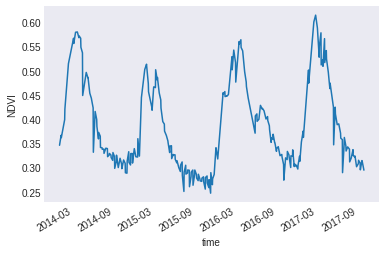

In [124]:
plt.clf()
NDVI_means = nbart_allsensors.NDVI.mean(dim =('x','y'))
NDVI_means.plot()
plt.show()

In [125]:
all_ndvi_sorted =nbart_allsensors['NDVI']


In [126]:

#del nbart_allsensors

###
\define dry seasons

In [127]:
def dry_season(month):
    '''filters on months to return a boolean mask of a dry season between may and november
    where month could be e.g. sensor3_nbart.time.dt.month'''
    return(month>=5)&(month<=10)

def dry_vals(sensor_data):
    if sensor_data is not None:
        '''calculates dry season values'''
        dry_data = sensor_data.sel(time = dry_season(sensor_data.time.dt.month))
        return dry_data
    else:
            return None 

### Linear regression code from Symington/Krause

In [128]:
#Define important functions and dictionaries
# See https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.linregress.html

#This function applies a linear regression to a grid over a set time interval
def linear_regression_grid(input_array, mask_no_trend = True, NDVI = False):
    '''
    This function applies a linear regression to a grid over a set time interval by looping through lat and lon 
    and calculating the linear regression through time for each pixel.
    '''

    ylen = len(input_array.y)
    xlen = len(input_array.x)
    from itertools import product
    coordinates = product(range(ylen), range(xlen))

    slopes = np.zeros((ylen, xlen))
    p_values = np.zeros((ylen, xlen))
    print('Slope shape is ', slopes.shape)

    for y, x in coordinates:
        val = input_array.isel(x = x, y = y)
        # If analysing NDVI data replace negative numbers which are spurious for NDVI with nans
        if NDVI == True:
            val[val<0] = np.nan

            # Check that we have at least three values to perform our linear regression on
            if np.count_nonzero(~np.isnan(val)) > 3:
                if str(val.dims[0]) == 'month':
                    slopes[y, x], intercept, r_sq, p_values[y, x], std_err = stats.linregress(val.month,val)
                elif str(val.dims[0]) == 'year':
                    slopes[y, x], intercept, r_sq, p_values[y, x], std_err = stats.linregress(val.year,val)
            else:
                slopes[y, x] = np.nan
                intercept = np.nan
                r_sq = np.nan
                p_values[y, x] = np.nan
        else:
            if str(val.dims[0]) == 'month':
                slopes[y, x], intercept, r_sq, p_values[y, x], std_err = stats.linregress(val.month,val)
            elif str(val.dims[0]) == 'year':
                slopes[y, x], intercept, r_sq, p_values[y, x], std_err = stats.linregress(val.year,val)

    #Get coordinates from the original xarray
    lat  = input_array.coords['y']
    long = input_array.coords['x']
    #Mask out values with insignificant trends (ie. p-value > 0.05) if user wants
    if mask_no_trend == True:
        slopes[p_values>0.05]=np.nan        
    # Write arrays into a x-array
    slope_xr = xr.DataArray(slopes, coords = [lat, long], dims = ['y', 'x'])
    p_val_xr = xr.DataArray(p_values, coords = [lat, long], dims = ['y', 'x']) 
    return slope_xr, p_val_xr

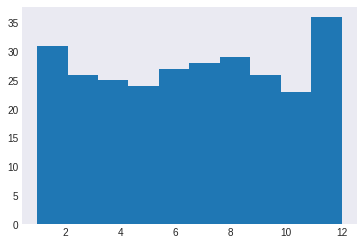

In [129]:
#plot the distribution of available surface reflectance scenes by month
plt.clf()
plt.hist(all_ndvi_sorted.time.dt.month.data)
plt.show()

In [130]:
def dry_vals(sensor_data):
    if sensor_data is not None:
        '''calculates dry season values'''
        dry_data = sensor_data.sel(time = dry_season(sensor_data.time.dt.month))
        return dry_data
    else:
            return None 

In [131]:
dry_data = all_ndvi_sorted.sel(time = dry_season(all_ndvi_sorted.time.dt.month))

In [132]:
dry_data.time.dt.month

<xarray.DataArray 'month' (time: 157)>
array([ 5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,
        7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,
       10, 10, 10, 10, 10, 10, 10,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,
        6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10,  5,
        5,  5,  5,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10,  5,
        5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,
        8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9])
Coordinates:
  * time     (time) datetime64[ns] 2014-05-01T00:25:35 ...

In [133]:
dry_ndvi = dry_vals(all_ndvi_sorted)

In [134]:
dry_ndvi

<xarray.DataArray 'NDVI' (time: 157, y: 540, x: 493)>
array([[[ 0.428847,  0.424166, ...,  0.40151 ,  0.41946 ],
        [ 0.414867,  0.436043, ...,  0.448184,  0.476902],
        ..., 
        [      nan,       nan, ...,  0.422157,  0.459271],
        [ 0.450355,  0.409875, ...,  0.441589,  0.453144]],

       [[      nan,       nan, ...,  0.376686,  0.422602],
        [ 0.417823,  0.408495, ...,  0.404112,  0.452481],
        ..., 
        [ 0.375473,  0.422074, ...,  0.42135 ,  0.44114 ],
        [ 0.375541,  0.398686, ...,       nan,  0.435018]],

       ..., 
       [[      nan,       nan, ...,  0.279116,  0.275   ],
        [      nan,       nan, ...,  0.326553,  0.323164],
        ..., 
        [ 0.279101,  0.275794, ...,  0.35778 ,  0.32524 ],
        [ 0.251064,  0.266777, ...,  0.334922,  0.337915]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ..., 
        [ 0.262725,  0.256571, ...,  0.32881 

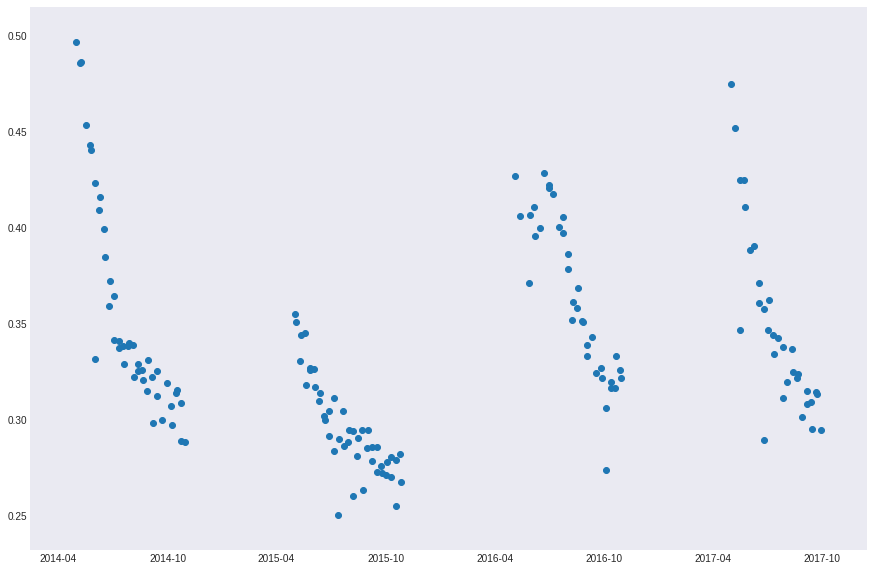

In [135]:
plt.clf()
fig = plt.figure(figsize =(15,10))
mean_dry_for_plots = dry_ndvi.mean(dim =('x','y'))
plt.scatter(mean_dry_for_plots.time.data,mean_dry_for_plots.data)
plt.show()

In [136]:
##### average yearly

In [137]:
averaged_data = dry_ndvi.groupby('time.month').mean(dim='time')

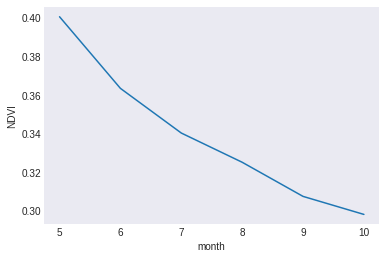

In [138]:
averaged_data.mean(dim=('x','y')).plot()
plt.show()

In [140]:
slope_xr_ndvi, p_val_xr_ndvi = linear_regression_grid(averaged_data, mask_no_trend = False, NDVI = True)

Slope shape is  (540, 493)


## Make a plot of the slope of the linear regression of the NDVI for each pixel

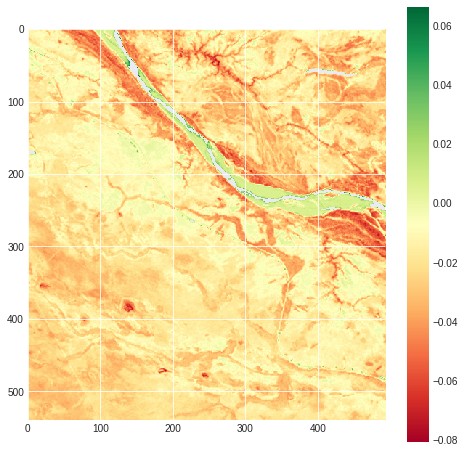

In [141]:
%matplotlib inline
plt.clf()
fig = plt.figure(figsize =(8,8))
plt.imshow(slope_xr_ndvi, cmap = 'RdYlGn')
plt.grid(True)
plt.colorbar()

# # #set up a file name with today's time and date in it
# write_time = datetime.datetime.strftime(datetime.datetime.now(), '%Y-%m-%d_%H:%M:%S')
# outfilename='/g/data/r78/rjd547/groundwater_activities/Mitchell/Plots/unmasked_ndvi'+shape_name+write_time+'.png'
# plt.savefig(outfilename)

plt.show()

## Save the slope and p value of the ndvi to file

In [142]:
picklefilepath = '/g/data/r78/rjd547/groundwater_activities/Mitchell/tmp/'

In [143]:
pickle.dump(slope_xr_ndvi, open(picklefilepath+'slope.pkl','wb'),protocol =-1)
pickle.dump(p_val_xr_ndvi, open(picklefilepath+'p_val.pkl','wb'),protocol =-1)
del slope_xr_ndvi
del p_val_xr_ndvi

## Calulate the masked slope and p val

In [144]:

slope_xr_ndvi_masked, p_val_xr_ndvi_masked = linear_regression_grid(averaged_data, mask_no_trend = True, NDVI = True)

Slope shape is  (540, 493)


/g/data/v10/public/modules/agdc-py3-env/20171016/envs/agdc/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


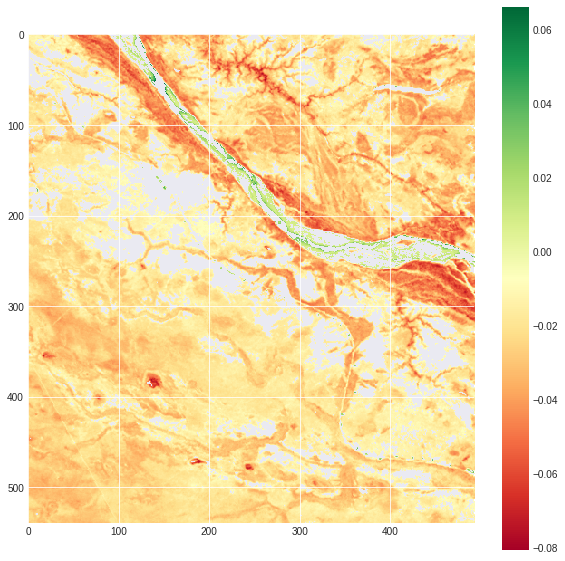

In [161]:
%matplotlib inline
plt.clf()
fig = plt.figure(figsize =(10,10))
plt.imshow(slope_xr_ndvi_masked, cmap = 'RdYlGn')#,vmin=-100,vmax=100)

plt.grid(True)
plt.colorbar()

# #set up a file name with today's time and date in it
# write_time = datetime.datetime.strftime(datetime.datetime.now(), '%Y-%m-%d_%H:%M:%S')
# outfilename='/g/data/r78/rjd547/groundwater_activities/Mitchell/Plots/'+shape_name+write_time+'.png'
# plt.savefig(outfilename)

plt.show()

In [162]:
nbart_allsensors

<xarray.Dataset>
Dimensions:  (time: 275, x: 493, y: 540)
Coordinates:
  * y        (y) float64 -1.759e+06 -1.759e+06 -1.759e+06 -1.759e+06 ...
  * x        (x) float64 1.149e+06 1.149e+06 1.149e+06 1.149e+06 1.149e+06 ...
  * time     (time) datetime64[ns] 2014-01-01T00:29:46 2014-01-08T00:35:51 ...
Data variables:
    green    (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    red      (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    nir      (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    swir1    (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    NDVI     (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
Attributes:
    crs:      EPSG:3577
    affine:   | 25.00, 0.00, 1148875.00|\n| 0.00,-25.00,-1759050.00|\n| 0.00,...

In [147]:
print ('The number of time slices at this location is '+ str(all_ndvi_sorted.shape[0])) 

The number of time slices at this location is 275


In [163]:
#pernan is a filtration level - scenes with more nans than this per scene are removed
pernan = 0.999999
nbart_allsensors = nbart_allsensors.dropna('time',  thresh = int(pernan*len(nbart_allsensors.x)*len(nbart_allsensors.y)))

MemoryError: 

In [ ]:
nbart_allsensors

In [63]:
#select time slice of interest - this is trial and error until you get a decent image
time_slice_i = 25
rgb = nbart_allsensors.isel(time =time_slice_i).to_array(dim='color').sel(color=['swir1', 'nir', 'green']).transpose('y', 'x', 'color')
#rgb = nbar_clean.isel(time =time_slice).to_array(dim='color').sel(color=['swir1', 'nir', 'green']).transpose('y', 'x', 'color')
fake_saturation = 4500
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

/g/data/v10/public/modules/agdc-py3-env/20171016/envs/agdc/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in less
  if not reflexive


Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


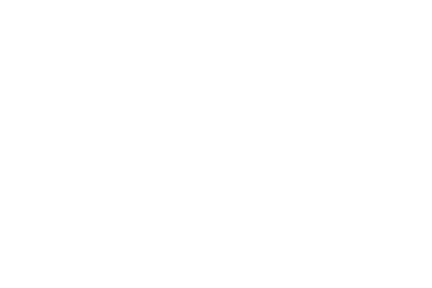

<IPython.core.display.Javascript object>


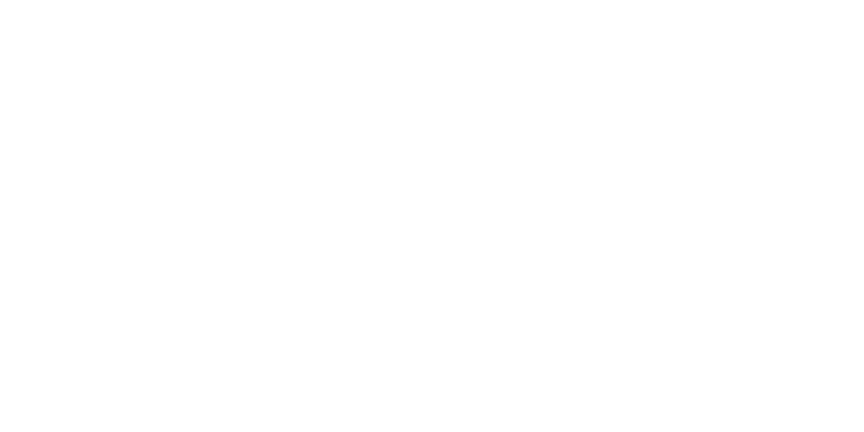

HTML(value='Event information appears here when you click on the figure')

<IPython.core.display.Javascript object>


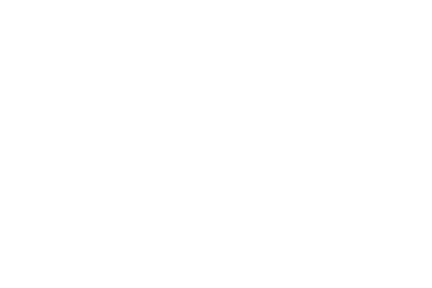

<IPython.core.display.Javascript object>


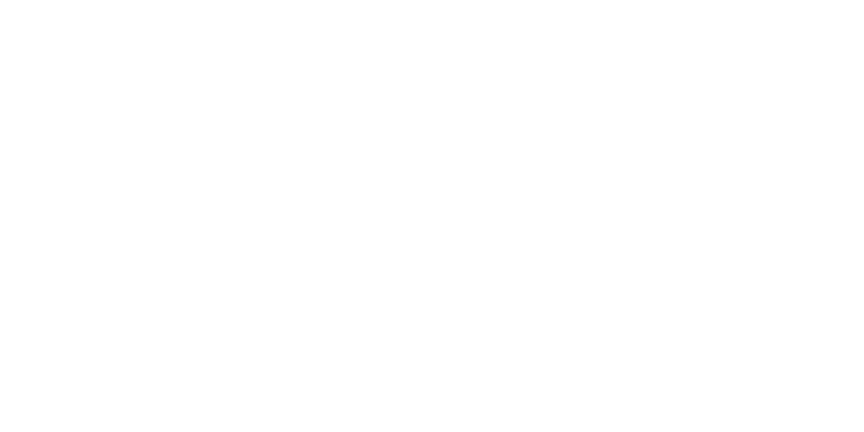

In [152]:
%pylab notebook
plt.clf()
#Click on this image to chose the location for time series extraction
w = widgets.HTML("Event information appears here when you click on the figure")
def callback(event):
    global x, y
    x, y = int(event.xdata + 0.5), int(event.ydata + 0.5)
    w.value = 'X: {}, Y: {}'.format(x,y)

fig = plt.figure(figsize =(12,6))
plt.imshow(scaled, interpolation = 'nearest',
           extent=[scaled.coords['x'].min(), scaled.coords['x'].max(), 
                   scaled.coords['y'].min(), scaled.coords['y'].max()])

fig.canvas.mpl_connect('button_press_event', callback)
date_ = nbart_allsensors.time[time_slice_i]
plt.title(date_.astype('datetime64[D]'))
plt.show()
display(w)

In [73]:
#this converts the map x coordinate into image x coordinates
image_coords = ~affine * (x, y)
imagex = int(image_coords[0])
imagey = int(image_coords[1])

NameError: name 'affine' is not defined

## Make phenology plot

In [71]:
mpl.style.use('seaborn-dark')

In [72]:
ts = all_ndvi_sorted.isel(x=[imagex],y=[imagey]).dropna('time', how = 'any')

mpl.style.use('seaborn-dark')

#MEASUREMENT = 'nir'

# Given ``data`` is an xarray.Dataset with dimensions ('time', 'y', 'x')
pix = ts

fig, ax = plt.subplots()

# Grabbing the day of year (for xaxis) and year (for color) made easier with xarray
sp = ax.scatter(pix['time.dayofyear'], pix, c=pix['time.year'],
                cmap=mpl.cm.jet, marker='o', edgecolor='none', s=35)
fig.colorbar(sp)

# If you want the months to show up as minor ticks...
month_doys = [dt.date(2000, m, 15).timetuple().tm_yday for m in range(1, 13)]
months = mpl.ticker.FixedLocator(month_doys)
months_fmrt = mpl.dates.DateFormatter('%b')

ax.xaxis.set_ticks(month_doys, minor=True)
ax.tick_params(axis='x', which='minor', direction='in', pad=-10)
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_minor_formatter(months_fmrt)

# Labels and axis limits are good
ax.grid(True)
ax.set_xlim((0, 366))
ax.set_ylim((0, 1))
ax.set_xlabel('Day of Year')
ax.set_ylabel('NDVI')
ax.set_title('Phenology "DOY Plot"')
plt.savefig('Phenology_DOY_Plot.png')
#in G/ Data
plt.savefig('/g/data/xa5/tmp/Phenology_DOY_Plot.png')

NameError: name 'imagex' is not defined

In [ ]:
# # DEfine functions
# def month_cut(data, month_1, month_2):

#     if data.dims[0] == 'time':
#         sliced_xr = list(data.groupby('time.month'))[monthDict[month_1]:monthDict[month_2] + 1]
#     elif data.dims[0] == 'month':
#         sliced_xr = list(data.groupby('month'))[monthDict[month_1]:monthDict[month_2] + 1]
    
#     #Concatenate all the arrays into one xarray
#     split_xr = sliced_xr[0][1]

    
#     for i in range(int(monthDict[month_2]) - int(monthDict[month_1])):
#         split_xr = xr.concat([split_xr, sliced_xr[i+1][1]], dim = data.dims[0])
                     
#     return split_xr

# #Finally we plot the regression for averaged daily or monthly data with a year(s) (eg. the May to October trend)
# # If multiple years are chosen then the monthly data is averaged over multiple years (eg all October data over time period
# # is averaged)

# # #Define time interval and months range
# # time_1 = '2014-01-01'
# # time_2 = '2016-12-31'
# # month_1 = 'April'
# # #You need at least 3 months to get a meaningful lilnear regression slope
# # month_2 = 'October'





# cut_data = all_ndvi_sorted.loc[time_1:time_2]

# averaged_data = cut_data.groupby('time.month').mean(dim='time')

# #Now plot a grid for this data

# month_cut(averaged_data, 'April', 'October')

# slope_xr_ndvi, p_val_xr_ndvi = linear_regression_grid(averaged_data, mask_no_trend = False, NDVI = True)

# fig = plt.figure(figsize =(11.69,5))
# plt.imshow(slope_xr_ndvi)

# plt.grid(True)
# plt.colorbar()

# plt.show()

In [164]:
%whos


Variable                  Type          Data/Info
-------------------------------------------------
NDVI_means                DataArray     <xarray.DataArray 'NDVI' <...>6 2014-01-08T00:35:51 ...
all_ndvi_sorted           DataArray     <xarray.DataArray 'NDVI' <...>6 2014-01-08T00:35:51 ...
averaged_data             DataArray     <xarray.DataArray 'NDVI' <...>month) int64 5 6 7 8 9 10
bands_of_interest         list          n=4
callback                  function      <function callback at 0x7f7eec1cf730>
clipped_visible           DataArray     <xarray.DataArray (y: 540<...>,-1759050.00|\n| 0.00,...
datacube                  module        <module 'datacube' from '<...>es/datacube/__init__.py'>
date_                     DataArray     <xarray.DataArray 'time' <...>since 1970-01-01 00:00:00
dc                        Datacube      Datacube<index=Index<db=P<...>244.105:6432/datacube)>>>
dry_data                  DataArray     <xarray.DataArray 'NDVI' <...>] 2014-05-01T00:25:35 ...
dry_ndvi  